In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Dataset and Visualisation

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
batch_size = 6

In [0]:
trainloader= torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels[0].item())


torch.Size([6, 1, 28, 28])
torch.Size([1, 28, 28])
5


In [0]:
def imshow(img, title):

    plt.figure(figsize=(batch_size*4, 4))
    plt.axis('OFF')
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.title(title)
    plt.show()

In [0]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))

    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

    return images, labels

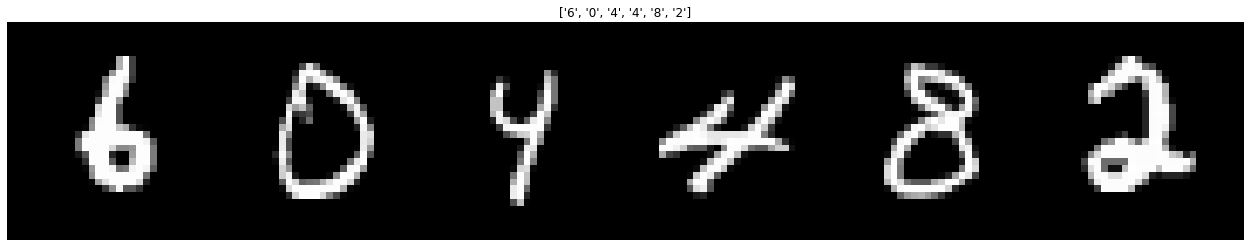

In [8]:
images, labels = show_batch_images(trainloader)

##Batch normalization

In [0]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )  
    def forward(self ,x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x  

In [0]:
class MyNetBN(nn.Module):
    def __init__(self):
        super(MyNetBN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [14]:
model = MyNet()
print(model)

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [15]:
model_bn = MyNetBN()
print(model_bn)

MyNetBN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [0]:
batch_size = 512

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [0]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

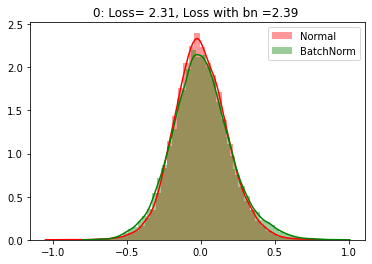

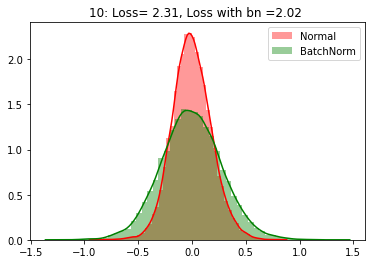

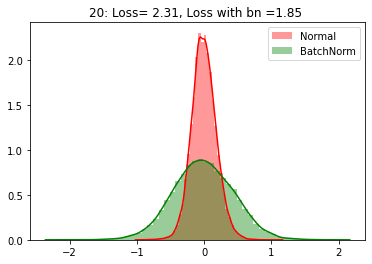

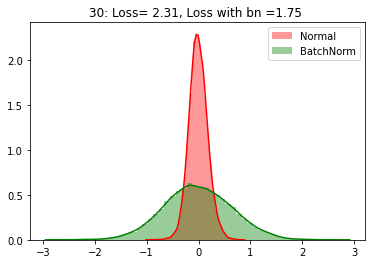

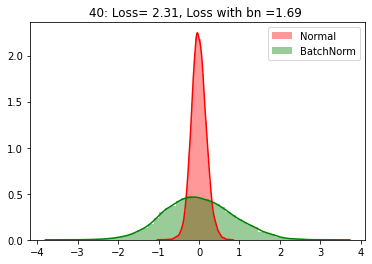

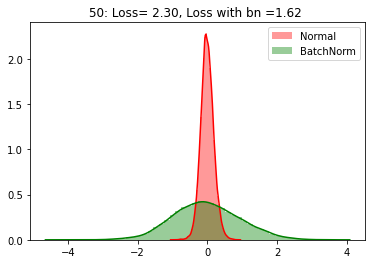

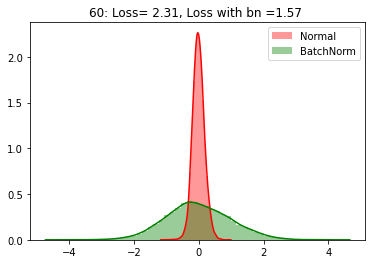

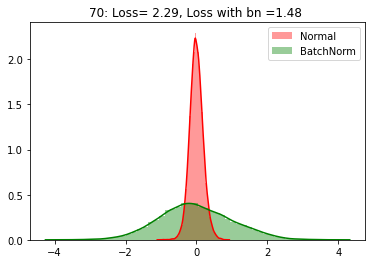

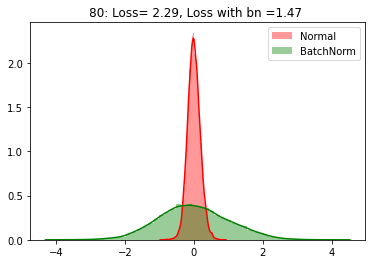

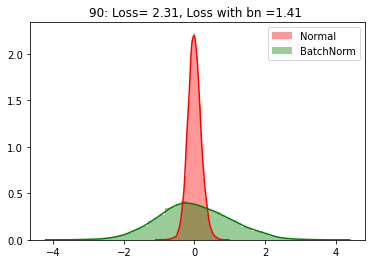

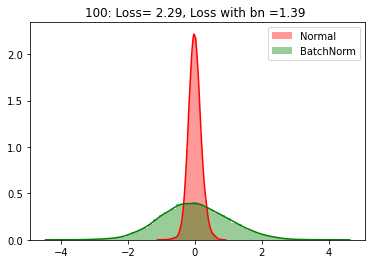

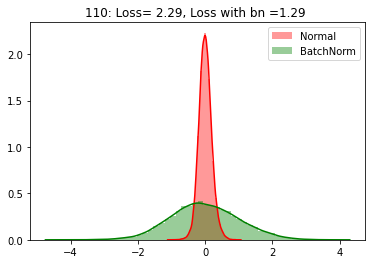

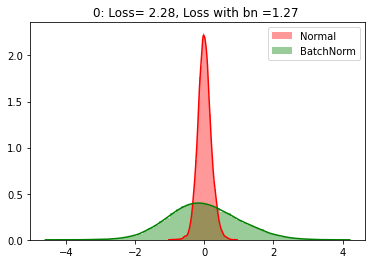

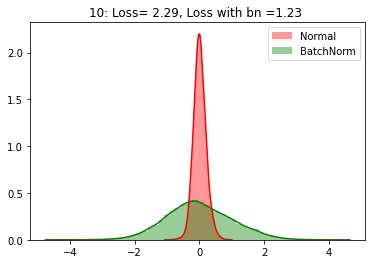

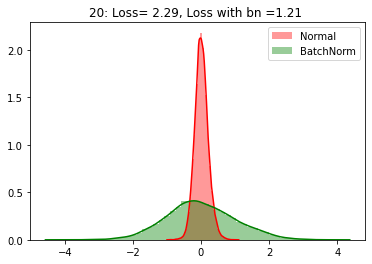

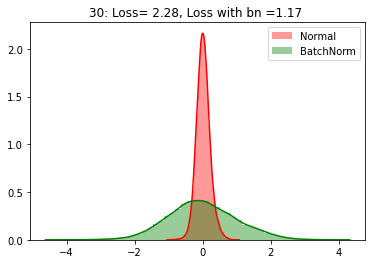

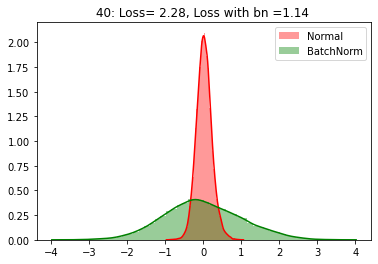

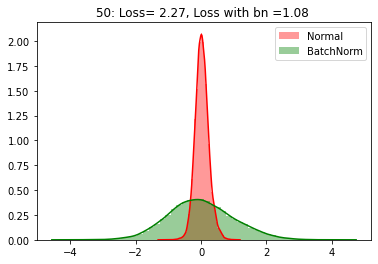

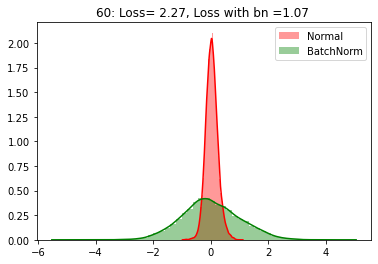

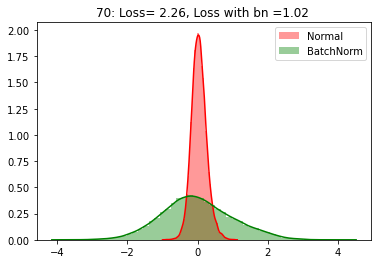

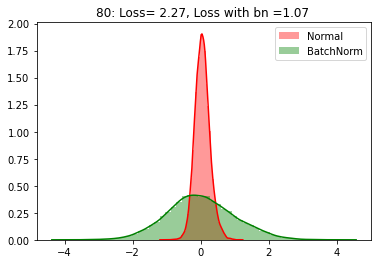

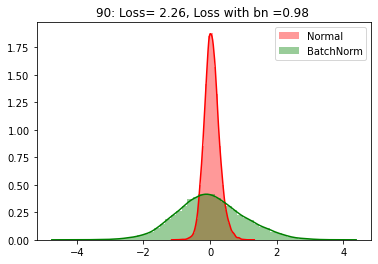

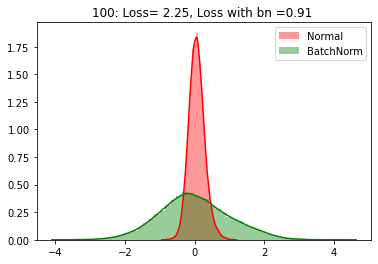

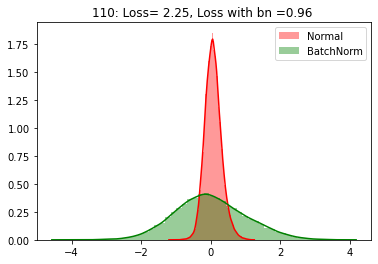

---------------------------


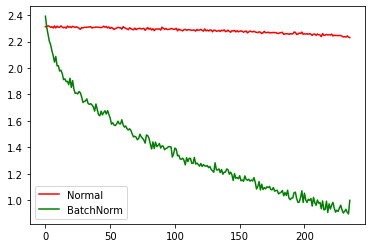

In [19]:
loss_arr = []
loss_bn_arr = []

max_epochs = 2

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        #training steps for normal model
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        #training setps for bn_model
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()

        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
        if i % 10 ==0:
            inputs = inputs.view(inputs.size(0),-1)

            model.eval()
            model_bn.eval()

            a=model.classifier[0](inputs)
            a = a.detach().numpy().ravel()
            sns.distplot(a, kde=True, color='r', label='Normal')

            b=model_bn.classifier[0](inputs)
            b=model_bn.classifier[1](b)
            b=b.detach().numpy().ravel()

            sns.distplot(b, kde=True, color='g', label='BatchNorm')
            plt.title('%d: Loss= %0.2f, Loss with bn =%0.2f ' % (i, loss.item(), loss_bn.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)

            model.train()
            model_bn.train()

print('---------------------------')

plt.plot(loss_arr, 'r', label='Normal')
plt.plot(loss_bn_arr, 'g', label='BatchNorm')
plt.legend()
plt.show()

In [0]:
class CNN_BN(nn.Module):
    def __init__(self):
        super(CNN_BN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(3, 6, 3),
            nn.BatchNorm2d(6)
        )
        self.features1 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(150, 25),
            nn.ReLU(),
            nn.Linear(25, 10)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.features1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [21]:
model = CNN_BN()
print(model)

CNN_BN(
  (features): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (features1): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=150, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=10, bias=True)
  )
)


In [0]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)

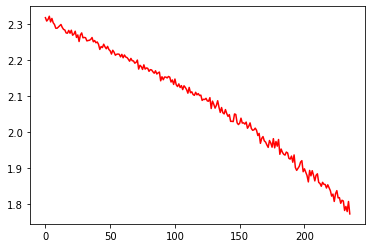

In [23]:
loss_arr = []

max_epochs = 2

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        loss_arr.append(loss.item())
        
plt.plot(loss_arr, 'r')
plt.show()

##Dropout

In [0]:
N = 100
noise = 0.4

X_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_train = X_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

X_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_test = X_test + noise*torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

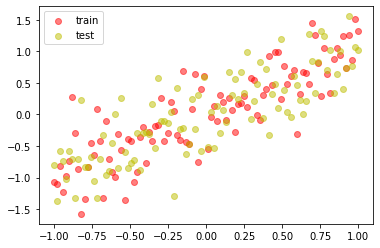

In [19]:
plt.scatter(X_train.data.numpy(), Y_train.data.numpy(),c='r', alpha=0.5, label='train')
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='y', alpha=0.5, label='test')
plt.legend()
plt.show()

In [0]:
N_h =100

model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(), 
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.1),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.1),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

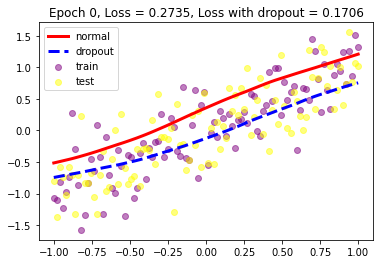

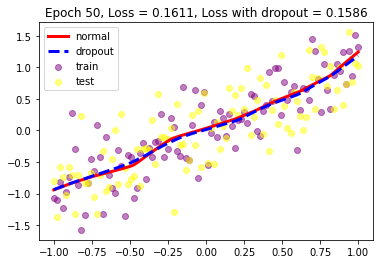

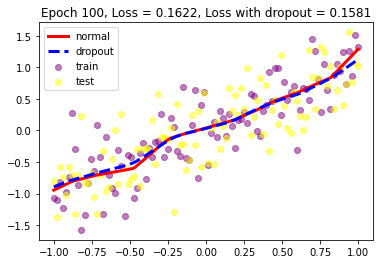

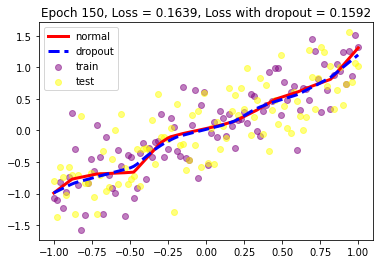

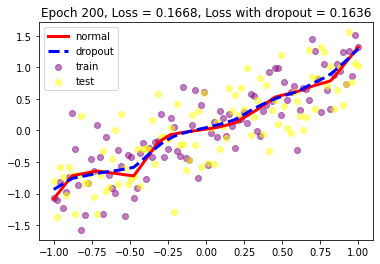

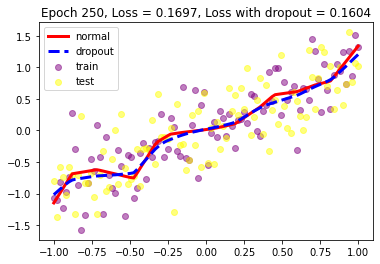

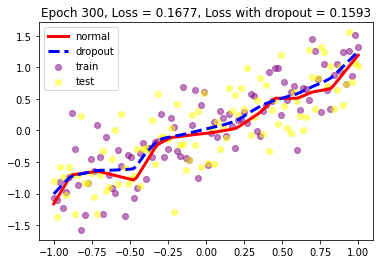

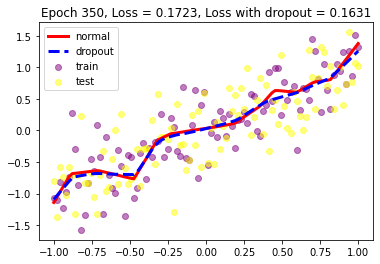

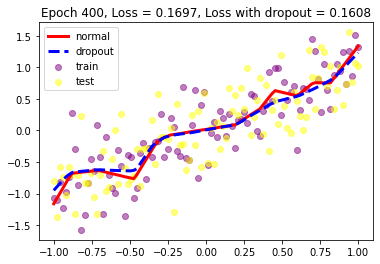

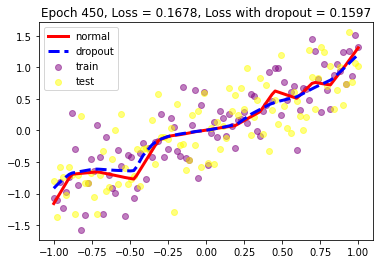

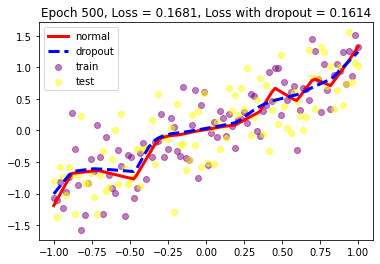

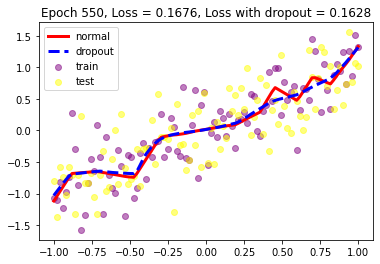

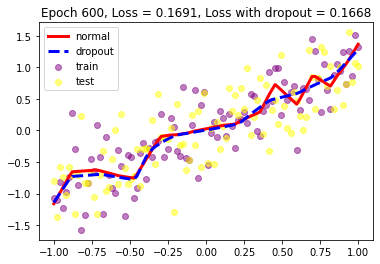

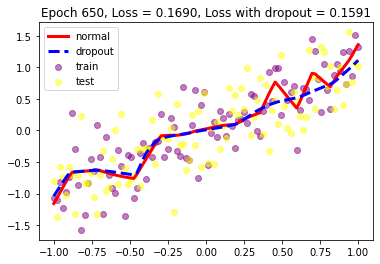

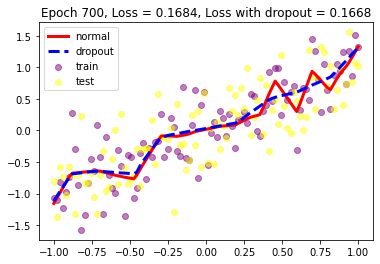

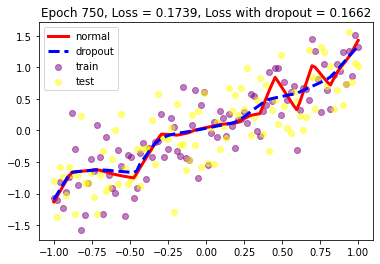

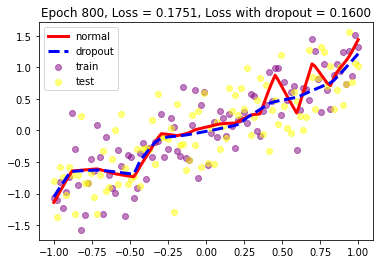

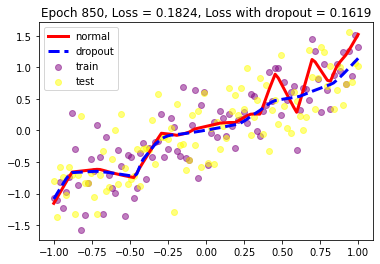

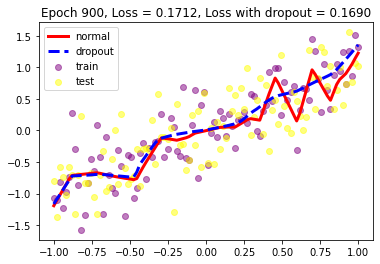

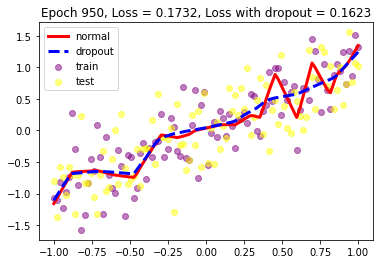

In [22]:
max_epochs = 1000

for epoch in range(max_epochs):

    pred = model(X_train) #look at the single shot
    loss = loss_fn(pred, Y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()

    pred_dropout = model_dropout(X_train)
    loss_dropout = loss_fn(pred_dropout, Y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()

    if epoch % 50 ==0:
        model.eval()
        model_dropout.eval()

        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, Y_test)
        
        test_pred_dropout = model_dropout(X_test)
        test_loss_dropout = loss_fn(test_pred_dropout, Y_test)

        plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(X_test.data.numpy(), test_pred.data.numpy(), 'r-', lw=3, label='normal')
        plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(), 'b--', lw=3, label='dropout')

        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' %(epoch, test_loss, test_loss_dropout))

        plt.legend()

        model.train()
        model_dropout.train()

        plt.pause(0.05)